## 利用KPCA进行异常检测

In [9]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import Model
from utils import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [8]:
# 加载测试数据

ood2label = {True: 0, False: 1}
data_test_1 = pd.read_csv('data_test_1.csv')
codes_test_1 = data_test_1['name'].to_list()
labels_test_1 = data_test_1['id'].map(lambda x: ood2label[x])
labels_test_1 = np.array(labels_test_1.to_list())
codes_test_1 = codes_loader(codes_test_1)

100%|██████████████████████████████████████████████████████████████████████████████| 1048/1048 [00:47<00:00, 22.21it/s]


In [11]:
model = keras.models.load_model('../model/malconv_split.h5')
layer_model = Model(inputs=model.input, outputs=model.layers[8].output)
feature_test = layer_model.predict(codes_test_1)
feature_train = np.load('feature_train.npy')

In [19]:
from methods.kpca import kPCA
from sklearn import metrics

model = kPCA(q = 64, sigma = 1.0985)
model.fit(feature_train)
test_scores = model.decision_function(feature_test)
test_auc = metrics.roc_auc_score(labels_test_1, test_scores)
print('test auc:', test_auc)

test auc: 0.9185794597559304


In [20]:
fpr, tpr, thresholds = metrics.roc_curve(labels_test_1, test_scores)

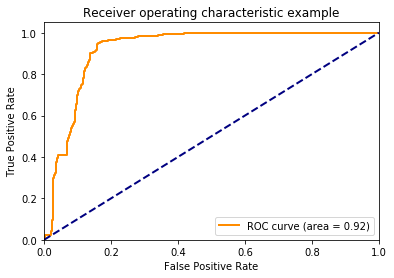

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
plt.savefig('./figures/kpca_auc.png')